In [1]:
import pandas as pd
import numpy as np
import pickle
import os, time
import shap
import cuml
from cuml.explainer import TreeExplainer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [2]:
# Reading CSV files, and merging all of them into a single DataFrame
CISIDS2017_folder = "/home/grassfed37/6CCS3PRJ/dummy-ML_NIDS/CICIDS2017ML"
CTU13_folder = "/home/grassfed37/6CCS3PRJ/dummy-ML_NIDS/CTU13ML"

CICIDS2017_df_list = []
CTU13_df_list = []

# Reading CICIDS2017 CSV files into a single DataFrame
for f in os.listdir(CISIDS2017_folder):
    file_path = os.path.join(CISIDS2017_folder, f)
    if os.path.isfile(file_path):
        print("Reading: ", f)
        CICIDS2017_df_list.append(pd.read_csv(file_path))

# Reading CTU13 CSV files into a single DataFrame
for f in os.listdir(CTU13_folder):
    file_path = os.path.join(CTU13_folder, f)
    if os.path.isfile(file_path):
        print("Reading: ", f)
        CTU13_df_list.append(pd.read_csv(file_path))

CICIDS2017_df, CTU13_df = pd.concat(CICIDS2017_df_list, ignore_index=True), pd.concat(CTU13_df_list, ignore_index=True)

Reading:  Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX_Relabeled.csv
Reading:  Friday-WorkingHours-Morning.pcap_ISCX_Relabeled.csv
Reading:  Wednesday-workingHours.pcap_ISCX_Relabeled.csv
Reading:  Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX_Relabeled.csv
Reading:  Monday-WorkingHours.pcap_ISCX_Relabeled.csv
Reading:  Friday-WorkingHours-Afternoon-DDos.pcap_ISCX_Relabeled.csv
Reading:  Tuesday-WorkingHours.pcap_ISCX_Relabeled.csv
Reading:  Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX_Relabeled.csv
Reading:  CTU13_Normal_Traffic_Relabeled.csv
Reading:  CTU13_Attack_Traffic_Relabeled.csv


In [3]:
# QUICK PREPROCESSING. 
# Some classifiers do not like "infinite" (inf) or "null" (NaN) values.
CICIDS2017_df.replace([np.inf, -np.inf], np.nan, inplace=True)
print("Columns with problematic values: ", list(CICIDS2017_df.columns[CICIDS2017_df.isna().any()]))
CICIDS2017_df.dropna(inplace=True)

CTU13_df.replace([np.inf, -np.inf], np.nan, inplace=True)
print("Columns with problematic values: ", list(CTU13_df.columns[CTU13_df.isna().any()]))
CTU13_df.dropna(inplace=True)

Columns with problematic values:  [' Flow Packets/s']
Columns with problematic values:  []


In [4]:
CICIDS2017_df[' Label'].unique()

array(['BENIGN', 'PortScan', 'Bot', 'DoS slowloris', 'DoS Slowhttptest',
       'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'DDoS', 'FTP-Patator', 'SSH-Patator',
       'Infiltration'], dtype=object)

In [5]:
CTU13_df[' Label'].unique()

array(['BENIGN', 'Bot'], dtype=object)

In [6]:
# Create a new column that unifies all malicious classes into a single class for binary classification
CICIDS2017_df['GT'] = np.where(CICIDS2017_df[' Label']=='BENIGN', 'Benign', 'Malicious')
CTU13_df['GT'] = np.where(CTU13_df[' Label']=='BENIGN', 'Benign', 'Malicious')

# Create an instance of LabelEncoder for 'GT' column
gt_encoder = LabelEncoder()

# Fit and transform 'GT' column for CICIDS2017_df
CICIDS2017_df['GT'] = gt_encoder.fit_transform(CICIDS2017_df['GT'])

# Fit and transform 'GT' column for CTU13_df 
CTU13_df['GT'] = gt_encoder.fit_transform(CTU13_df['GT'])


# Perform label encoding on the 'Label' column for each DataFrame separately
CICIDS2017_df[' Label'] = LabelEncoder().fit_transform(CICIDS2017_df[' Label'])
CTU13_df[' Label'] = LabelEncoder().fit_transform(CTU13_df[' Label'])

In [7]:
features = pd.Index([
    ' Flow Duration',
    ' Total Fwd Packets',
    ' Total Backward Packets',
    ' Total Length of Bwd Packets',
    ' Fwd Packet Length Max',
    ' Fwd Packet Length Min',
    ' Fwd Packet Length Mean',
    ' Fwd Packet Length Std',
    ' Bwd Packet Length Min',
    ' Bwd Packet Length Mean',
    ' Bwd Packet Length Std',
    ' Flow Packets/s',
    ' Flow IAT Mean',
    ' Flow IAT Std',
    ' Flow IAT Max',
    ' Flow IAT Min',
    ' Fwd IAT Mean',
    ' Fwd IAT Std',
    ' Fwd IAT Max',
    ' Fwd IAT Min',
    ' Bwd IAT Mean',
    ' Bwd IAT Std',
    ' Bwd IAT Max',
    ' Bwd IAT Min',
    ' Bwd PSH Flags',
    ' Fwd Header Length',
    ' Bwd Header Length',
    ' Bwd Packets/s',
    ' Min Packet Length',
    ' Max Packet Length',
    ' Packet Length Mean',
    ' Packet Length Std',
    ' Packet Length Variance',
    ' SYN Flag Count',
    ' RST Flag Count',
    ' ACK Flag Count',
    ' Down/Up Ratio',
    ' Average Packet Size',
    ' Avg Fwd Segment Size',
    ' Avg Bwd Segment Size',
    ' Init_Win_bytes_backward',
    ' act_data_pkt_fwd',
    ' Active Std',
    ' Active Max',
    ' Active Min',
    ' Idle Std',
    ' Idle Max',
    ' Idle Min'
])

In [8]:
# Encode feature columns to float32
CTU13_df[features] = CTU13_df[features].astype('float32')
CTU13_df['GT'] = CTU13_df['GT'].astype('float32')
CICIDS2017_df[features] = CICIDS2017_df[features].astype('float32')
CICIDS2017_df['GT'] = CICIDS2017_df['GT'].astype('float32')

In [9]:
# Train test splits for both datasets
train_ctu13, test_ctu13 = train_test_split(CTU13_df, test_size=0.4, stratify=CTU13_df['GT'])
train_cicids, test_cicids = train_test_split(CICIDS2017_df, test_size=0.4, stratify=CICIDS2017_df['GT'])

start = time.time()
rfClf_bin_ctu13 = cuml.ensemble.RandomForestClassifier()
rfClf_bin_ctu13.fit(train_ctu13[features], train_ctu13['GT'])
end = time.time() - start
print("Training time (CTU13 Binary): ", end)

# Save the binary Random Forest model trained on CTU13 dataset
with open('../Pickle Files/RFBinaryCTU13.pkl', 'wb') as file:
    pickle.dump(rfClf_bin_ctu13, file)
    print("Model saved to: ", file.name)

Training time (CTU13 Binary):  0.7344117164611816
Model saved to:  ../Pickle Files/RFBinaryCTU13.pkl


In [10]:
# Train test splits for both datasets
train_ctu13, test_ctu13 = train_test_split(CTU13_df, test_size=0.4, stratify=CTU13_df['GT'])
train_cicids, test_cicids = train_test_split(CICIDS2017_df, test_size=0.4, stratify=CICIDS2017_df['GT'])

start = time.time()
rfClf_bin_cicids = cuml.ensemble.RandomForestClassifier()
rfClf_bin_cicids.fit(train_cicids[features], train_cicids['GT'])
end = time.time() - start
print("Training time (CICIDS2017 Binary): ", end)

# Save the binary Random Forest model trained on CICIDS2017 dataset
with open('../Pickle Files/RFBinaryCICIDS2017.pkl', 'wb') as file:
    pickle.dump(rfClf_bin_cicids, file)
    print("Model saved to: ", file.name)

Training time (CICIDS2017 Binary):  14.040158987045288
Model saved to:  ../Pickle Files/RFBinaryCICIDS2017.pkl


In [ ]:
# Train test splits for both datasets
train_ctu13, test_ctu13 = train_test_split(CTU13_df, test_size=0.4, stratify=CTU13_df['GT'])
train_cicids, test_cicids = train_test_split(CICIDS2017_df, test_size=0.4, stratify=CICIDS2017_df['GT'])

# Train a Multiclass Random Forest model on CICIDS2017 dataset
start = time.time()
rfClf_multi_cicids = cuml.ensemble.RandomForestClassifier()
rfClf_multi_cicids.fit(train_cicids[features], train_cicids[' Label'])
end = time.time() - start
print("Training time (CICIDS2017 Multiclass): ", end)

# Save the multiclass Random Forest model trained on CICIDS2017 dataset
with open('../Pickle Files/RFMulticlassCICIDS2017.pkl', 'wb') as file:
    pickle.dump(rfClf_multi_cicids, file)
    print("Model saved to: ", file.name)

Training time (CICIDS2017 Multiclass):  15.642515659332275
Model saved to:  ../Pickle Files/RFMulticlassCICIDS2017.pkl


In [ ]:
# Train test splits for both datasets
train_ctu13, test_ctu13 = train_test_split(CTU13_df, test_size=0.4, stratify=CTU13_df['GT'])
train_cicids, test_cicids = train_test_split(CICIDS2017_df, test_size=0.4, stratify=CICIDS2017_df['GT'])

# Load the binary Random Forest model trained on CTU13 dataset
with open('../Pickle Files/RFBinaryCTU13.pkl', 'rb') as file:
    rfClf_bin_ctu13 = pickle.load(file)
    print("Model loaded from: ", file.name)
    
# Create a SHAP explainer using gputreexplainer
explainer_ctu13 = TreeExplainer(model=rfClf_bin_ctu13)
print("SHAP explainer created")

# Get SHAP values against the CTU13 test set
shap_values_ctu13 = explainer_ctu13.shap_values(test_ctu13[features])
print("SHAP values calculated")

# Save SHAP values to a .pkl file
with open('../Pickle Files/shap_values_RFBinaryCTU13.pkl', 'wb') as file:
    pickle.dump(shap_values_ctu13, file)
    print("SHAP values saved to: ", file.name)

Model loaded from:  ../Pickle Files/RFBinaryCTU13.pkl
SHAP explainer created
SHAP values calculated
SHAP values saved to:  ../Pickle Files/shap_values_RFBinaryCTU13.pkl


In [ ]:
# Train test splits for both datasets
train_ctu13, test_ctu13 = train_test_split(CTU13_df, test_size=0.4, stratify=CTU13_df['GT'])
train_cicids, test_cicids = train_test_split(CICIDS2017_df, test_size=0.4, stratify=CICIDS2017_df['GT'])

# Load the binary Random Forest model trained on CICIDS2017 dataset
with open('../Pickle Files/RFBinaryCICIDS2017.pkl', 'rb') as file:
    rfClf_bin_cicids = pickle.load(file)
    print("Model loaded from: ", file.name)
    
# Create a SHAP explainer
explainer_cicids_binary = TreeExplainer(model=rfClf_bin_cicids)
print("SHAP explainer created")

# Get SHAP values against the CICIDS2017 test set
shap_values_cicids_binary = explainer_cicids_binary.shap_values(test_cicids[features])
print("SHAP values calculated")

# Save SHAP values to a .pkl file
with open('../Pickle Files/shap_values_RFBinaryCICIDS2017.pkl', 'wb') as file:
    pickle.dump(shap_values_cicids_binary, file)
    print("SHAP values saved to: ", file.name)

Model loaded from:  ../Pickle Files/RFBinaryCICIDS2017.pkl
SHAP explainer created
SHAP values calculated
SHAP values saved to:  ../Pickle Files/shap_values_RFBinaryCICIDS2017.pkl


In [12]:
# Train test splits for both datasets
train_ctu13, test_ctu13 = train_test_split(CTU13_df, test_size=0.4, stratify=CTU13_df['GT'])
train_cicids, test_cicids = train_test_split(CICIDS2017_df, test_size=0.4, stratify=CICIDS2017_df['GT'])

# Load the binary Random Forest model trained on CTU13 dataset
with open('../Pickle Files/RFBinaryCTU13.pkl', 'rb') as file:
    rfClf_bin_ctu13 = pickle.load(file)
    print("Model loaded from: ", file.name)
    
# Test on CTU13 dataset
predictions_bin_ctu13 = rfClf_bin_ctu13.predict(test_ctu13[features])

# Now compute the metrics
print("Acc (CTU13 Binary): {:.3f}".format(accuracy_score(test_ctu13['GT'], predictions_bin_ctu13)))
print("Precision (CTU13 Binary): {:.3f}".format(precision_score(test_ctu13['GT'], predictions_bin_ctu13, pos_label=1)))
print("Recall (CTU13 Binary): {:.3f}".format(recall_score(test_ctu13['GT'], predictions_bin_ctu13, pos_label=1)))
print("F1-score (CTU13 Binary): {:.3f}".format(f1_score(test_ctu13['GT'], predictions_bin_ctu13, pos_label=1)))

# Confusion Matrix
pd.crosstab(test_ctu13['GT'], predictions_bin_ctu13, rownames=['True'], colnames=['Pred'])

Model loaded from:  ../Pickle Files/RFBinaryCTU13.pkl
Acc (CTU13 Binary): 0.998
Precision (CTU13 Binary): 0.997
Recall (CTU13 Binary): 0.997
F1-score (CTU13 Binary): 0.997


Pred,0.0,1.0
True,,
0.0,21286,40
1.0,43,15516


In [13]:
# Train test splits for both datasets
train_ctu13, test_ctu13 = train_test_split(CTU13_df, test_size=0.4, stratify=CTU13_df['GT'])
train_cicids, test_cicids = train_test_split(CICIDS2017_df, test_size=0.4, stratify=CICIDS2017_df['GT'])

# Load the binary Random Forest model trained on CICIDS2017 dataset
with open('../Pickle Files/RFBinaryCICIDS2017.pkl', 'rb') as file:
    rfClf_bin_cicids = pickle.load(file)
    print("Model loaded from: ", file.name)

# Test on CICIDS2017 dataset
predictions_bin_cicids = rfClf_bin_cicids.predict(test_cicids[features])
print("Acc (CICIDS2017 Binary): {:3f}".format(accuracy_score(test_cicids['GT'], predictions_bin_cicids)))
print("Precision (CICIDS2017 Binary): {:3f}".format(precision_score(test_cicids['GT'], predictions_bin_cicids, pos_label=1)))
print("Recall (CICIDS2017 Binary): {:3f}".format(recall_score(test_cicids['GT'], predictions_bin_cicids, pos_label=1)))
print("F1-score (CICIDS2017 Binary): {:3f}".format(f1_score(test_cicids['GT'], predictions_bin_cicids, pos_label=1)))
pd.crosstab(test_cicids['GT'], predictions_bin_cicids, rownames=['True'], colnames=['Pred'])

Model loaded from:  ../Pickle Files/RFBinaryCICIDS2017.pkl
Acc (CICIDS2017 Binary): 0.988840
Precision (CICIDS2017 Binary): 0.962091
Recall (CICIDS2017 Binary): 0.981987
F1-score (CICIDS2017 Binary): 0.971937


Pred,0.0,1.0
True,,
0.0,899914,8614
1.0,4010,218613


In [14]:
# Train test splits for both datasets
train_ctu13, test_ctu13 = train_test_split(CTU13_df, test_size=0.4, stratify=CTU13_df['GT'])
train_cicids, test_cicids = train_test_split(CICIDS2017_df, test_size=0.4, stratify=CICIDS2017_df['GT'])

# Load the multiclass Random Forest model trained on CICIDS2017 dataset
with open('../Pickle Files/RFMulticlassCICIDS2017.pkl', 'rb') as file:
    rfClf_multi_cicids = pickle.load(file)
    print("Model loaded from: ", file.name)

# Test on CICIDS2017 dataset
predictions_multi_cicids = rfClf_multi_cicids.predict(test_cicids[features])
print("Acc (CICIDS2017 Multiclass): {:3f}".format(accuracy_score(test_cicids[' Label'], predictions_multi_cicids)))
print("Precision (CICIDS2017 Multiclass): {:3f}".format(precision_score(test_cicids[' Label'], predictions_multi_cicids, average='macro')))
print("Recall (CICIDS2017 Multiclass): {:3f}".format(recall_score(test_cicids[' Label'], predictions_multi_cicids, average='macro')))
print("F1-score (CICIDS2017 Multiclass): {:3f}".format(f1_score(test_cicids[' Label'], predictions_multi_cicids, average='macro')))
pd.crosstab(test_cicids[' Label'], predictions_multi_cicids, rownames=['True'], colnames=['Pred'])

Model loaded from:  ../Pickle Files/RFMulticlassCICIDS2017.pkl
Acc (CICIDS2017 Multiclass): 0.988478
Precision (CICIDS2017 Multiclass): 0.966339
Recall (CICIDS2017 Multiclass): 0.739058
F1-score (CICIDS2017 Multiclass): 0.771359


Pred,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
True,,,,,,,,,,,,,,,
0,899953,0,54,1,8000,149,4,14,0,0,350,0,3,0,0
1,523,311,0,0,0,0,0,0,0,0,0,0,0,0,0
2,53,0,51258,0,0,0,0,0,0,0,0,0,0,0,0
3,119,0,0,4050,1,1,0,0,0,0,0,0,0,0,0
4,2092,0,1,0,89859,0,0,0,0,0,0,0,0,0,0
5,14,0,0,0,0,2207,5,0,0,0,0,0,1,0,0
6,15,0,0,0,0,3,2315,0,0,0,0,0,2,0,0
7,45,0,0,0,0,0,0,3146,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0


In [15]:
# Train test splits for both datasets
train_ctu13, test_ctu13 = train_test_split(CTU13_df, test_size=0.4, stratify=CTU13_df['GT'])
train_cicids, test_cicids = train_test_split(CICIDS2017_df, test_size=0.4, stratify=CICIDS2017_df['GT'])

# Load the binary Random Forest model trained on CTU13 dataset
with open('../Pickle Files/RFBinaryCTU13.pkl', 'rb') as file:
    rfClf_bin_ctu13 = pickle.load(file)
    print("Model loaded from: ", file.name)

# Test on CICIDS2017 dataset
predictions_bin_cicids = rfClf_bin_ctu13.predict(test_cicids[features])
print("Acc (CTU13 to CICIDS2017): {:3f}".format(accuracy_score(test_cicids['GT'], predictions_bin_cicids)))
print("Precision (CTU13 to CICIDS2017): {:3f}".format(precision_score(test_cicids['GT'], predictions_bin_cicids, pos_label=1)))
print("Recall (CTU13 to CICIDS2017): {:3f}".format(recall_score(test_cicids['GT'], predictions_bin_cicids, pos_label=1)))
print("F1-score (CTU13 to CICIDS2017): {:3f}".format(f1_score(test_cicids['GT'], predictions_bin_cicids, pos_label=1)))
pd.crosstab(test_cicids['GT'], predictions_bin_cicids, rownames=['True'], colnames=['Pred'])

Model loaded from:  ../Pickle Files/RFBinaryCTU13.pkl
Acc (CTU13 to CICIDS2017): 0.344246
Precision (CTU13 to CICIDS2017): 0.177366
Recall (CTU13 to CICIDS2017): 0.640972
F1-score (CTU13 to CICIDS2017): 0.277847


Pred,0.0,1.0
True,,
0.0,246699,661829
1.0,79928,142695


In [16]:
# Train test splits for both datasets
train_ctu13, test_ctu13 = train_test_split(CTU13_df, test_size=0.4, stratify=CTU13_df['GT'])
train_cicids, test_cicids = train_test_split(CICIDS2017_df, test_size=0.4, stratify=CICIDS2017_df['GT'])

# Load the binary Random Forest model trained on CICIDS2017
with open('../Pickle Files/RFBinaryCICIDS2017.pkl', 'rb') as file:
    rfClf_bin = pickle.load(file)
    print("Model loaded from: ", file.name)

# Test on CTU13 dataset
predictions_bin = rfClf_bin.predict(test_ctu13[features])
print("Acc (CICIDS2017 Binary to CTU13): {:3f}".format(accuracy_score(test_ctu13['GT'], predictions_bin)))
print("Precision (CICIDS2017 Binary to CTU13): {:3f}".format(precision_score(test_ctu13['GT'], predictions_bin, pos_label=1)))
print("Recall (CICIDS2017 Binary to CTU13): {:3f}".format(recall_score(test_ctu13['GT'], predictions_bin, pos_label=1)))
print("F1-score (CICIDS2017 Binary to CTU13): {:3f}".format(f1_score(test_ctu13['GT'], predictions_bin, pos_label=1)))
pd.crosstab(test_ctu13['GT'], predictions_bin, rownames=['True'], colnames=['Pred'])

Model loaded from:  ../Pickle Files/RFBinaryCICIDS2017.pkl
Acc (CICIDS2017 Binary to CTU13): 0.578284
Precision (CICIDS2017 Binary to CTU13): 1.000000
Recall (CICIDS2017 Binary to CTU13): 0.000257
F1-score (CICIDS2017 Binary to CTU13): 0.000514


Pred,0.0,1.0
True,,
0.0,21326,0
1.0,15555,4


In [17]:
# Train test splits for both datasets
train_ctu13, test_ctu13 = train_test_split(CTU13_df, test_size=0.4, stratify=CTU13_df['GT'])
train_cicids, test_cicids = train_test_split(CICIDS2017_df, test_size=0.4, stratify=CICIDS2017_df['GT'])

# Load the multiclass Random Forest model trained on CICIDS2017
with open('../Pickle Files/RFMulticlassCICIDS2017.pkl', 'rb') as file:
    rfClf_multi = pickle.load(file)
    print("Model loaded from: ", file.name)

# Test on CTU13 dataset
predictions_multi = rfClf_multi.predict(test_ctu13[features])
print("Acc (CICIDS2017 Multi-class to CTU13): {:3f}".format(accuracy_score(test_ctu13[' Label'], predictions_multi)))
print("Precision (CICIDS2017 Multi-class to CTU13): {:3f}".format(precision_score(test_ctu13[' Label'], predictions_multi, average='macro')))
print("Recall (CICIDS2017 Multi-class to CTU13): {:3f}".format(recall_score(test_ctu13[' Label'], predictions_multi, average='macro')))
print("F1-score (CICIDS2017 Multi-class to CTU13): {:3f}".format(f1_score(test_ctu13[' Label'], predictions_multi, average='macro')))
pd.crosstab(test_ctu13[' Label'], predictions_multi, rownames=['True'], colnames=['Pred'])

Model loaded from:  ../Pickle Files/RFMulticlassCICIDS2017.pkl
Acc (CICIDS2017 Multi-class to CTU13): 0.578175
Precision (CICIDS2017 Multi-class to CTU13): 0.192730
Recall (CICIDS2017 Multi-class to CTU13): 0.333333
F1-score (CICIDS2017 Multi-class to CTU13): 0.244242


/home/grassfed37/miniconda3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/grassfed37/miniconda3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Pred,0.0,4.0
True,,
0,21326,0
1,15558,1


SHAP values loaded from:  ../Pickle Files/shap_values_RFBinaryCTU13.pkl


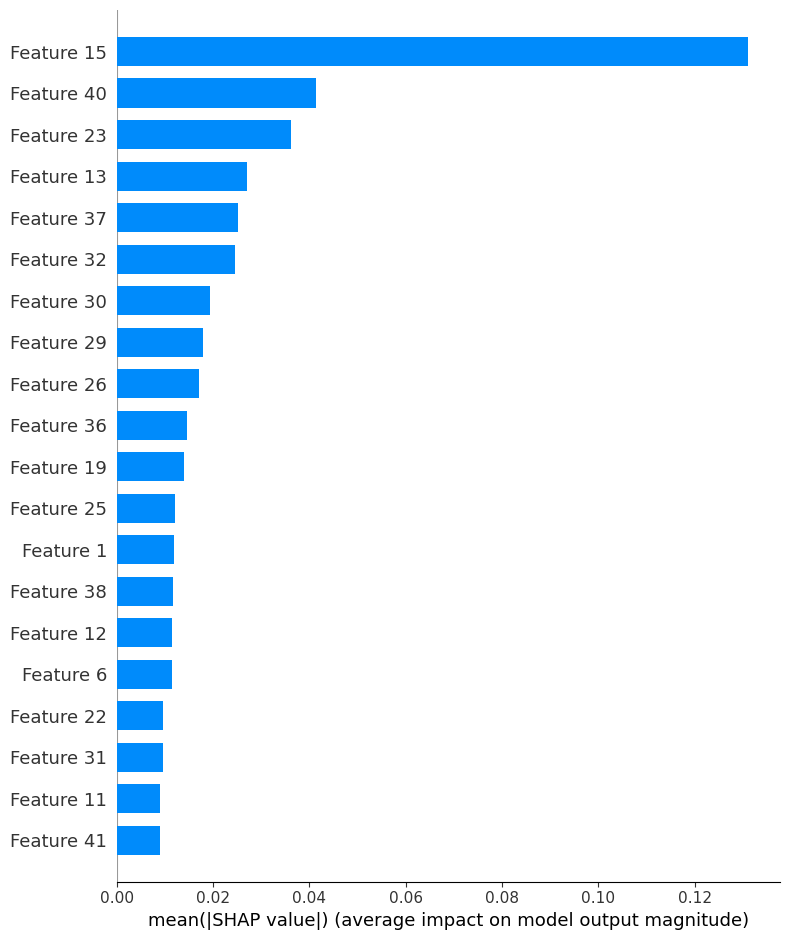

In [19]:
# Train test splits for both datasets
train_ctu13, test_ctu13 = train_test_split(CTU13_df, test_size=0.4, stratify=CTU13_df['GT'])
train_cicids, test_cicids = train_test_split(CICIDS2017_df, test_size=0.4, stratify=CICIDS2017_df['GT'])

# Load SHAP values from a .pkl file
with open('../Pickle Files/shap_values_RFBinaryCTU13.pkl', 'rb') as file:
    shap_values_ctu13 = pickle.load(file)
    print("SHAP values loaded from: ", file.name)

test_ctu13_np = test_ctu13[features].to_numpy()

# Generate a bar plot for the SHAP values against the CTU13 test set
shap.summary_plot(shap_values_ctu13[0].get(), test_ctu13_np, plot_type="bar")

SHAP values loaded from:  ../Pickle Files/shap_values_RFBinaryCICIDS2017.pkl


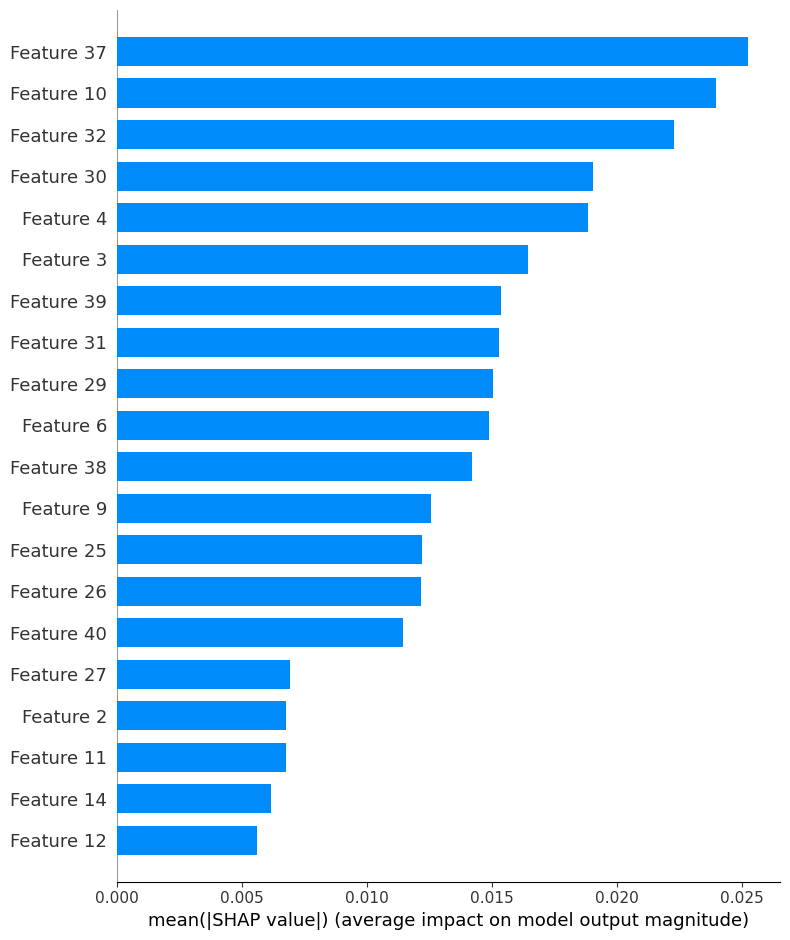

In [21]:
# Train test splits for both datasets
train_ctu13, test_ctu13 = train_test_split(CTU13_df, test_size=0.4, stratify=CTU13_df['GT'])
train_cicids, test_cicids = train_test_split(CICIDS2017_df, test_size=0.4, stratify=CICIDS2017_df['GT'])

# Load SHAP values from a .pkl file
with open('../Pickle Files/shap_values_RFBinaryCICIDS2017.pkl', 'rb') as file:
    shap_values_cicids_binary = pickle.load(file)
    print("SHAP values loaded from: ", file.name)

test_cicids_bin_np = test_cicids[features].to_numpy()

# Generate a bar plot for the SHAP values against the CICIDS2017 test set
shap.summary_plot(shap_values_cicids_binary[0].get(), test_cicids_bin_np, plot_type="bar")